In [1]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
multiprocessing.set_start_method("fork", force=True)

from orbit.utils.stan import get_compiled_stan_model_simplified, compile_stan_model_simplified
from orbit.utils.dataset import load_iclaims
import arviz as az

In [2]:
ss_model_path = "../stan/ss_local_level.stan"
compiled_path = compile_stan_model_simplified(ss_model_path)
ss_mod = get_compiled_stan_model_simplified(compiled_path)
del compiled_path

In [3]:
# fake data
# np.random.seed(2022)
# x = np.random.normal(0, 0.2, 100)
# y = np.cumsum(x) + np.random.normal(0, 1.0, 100)
# y = (y - np.mean(y))/np.std(y)

In [4]:
raw_data = load_iclaims()
y = raw_data['claims']
y = (y - np.mean(y))/np.std(y)

In [5]:
data = {
    'N': len(y),
    'Y' : y,
    'SD_Y' : 1.0,
    'A1' : y[0],
    'P1' : 0.0,
    'STATE_SIGMA_MEAN': 0.1,
    'STATE_SIGMA_SD': 1.0,
    'OBS_SIGMA_MEAN': 0.8,
    'OBS_SIGMA_SD': 1.0,
}

In [6]:
ss_fit = ss_mod.sampling(
    data=data,
    warmup=4000,
    iter=5000,
    chains=4,
)


Gradient evaluation took 0.000127 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.27 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)

Gradient evaluation took 0.000121 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.21 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)

Gradient evaluation took 0.000121 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.21 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)

Gradient evaluation took 8.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 5000 [  0%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration:  500 / 5000 [ 10%]  (Warmup)
Iteration: 1000 / 5000 [ 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


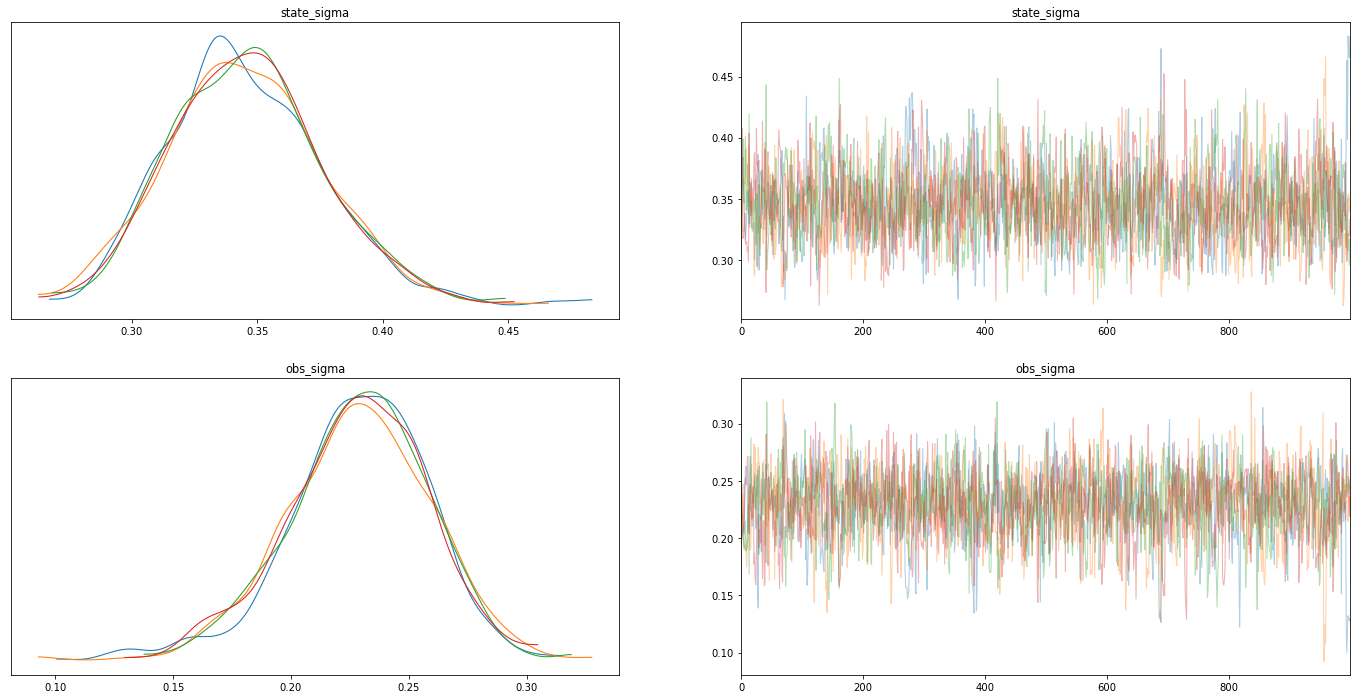

In [7]:
az_posteriors = az.from_pystan(ss_fit)
az.plot_trace(az_posteriors, var_names=['state_sigma', 'obs_sigma'], compact=False, figsize=(24, 12));

In [13]:
ss_posteriors = ss_fit.extract(pars=['state_sigma', 'states', 'obs_sigma'], permuted=True)
yhat = ss_posteriors['states'][:, :-1]
yhat_upper, yhat_med, yhat_lower = np.quantile(yhat, q=[0.9, 0.5, 0.1], axis=0)

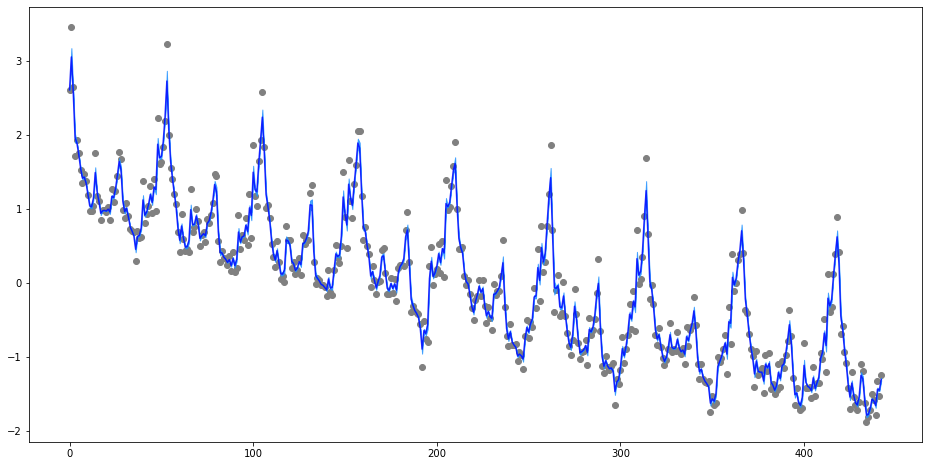

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
x = np.arange(0, len(y))
ax.scatter(x, y, c='grey')
ax.plot(x, yhat_med, color='blue', alpha=0.8);
ax.fill_between(x=x, y1=yhat_lower, y2=yhat_upper, color='dodgerblue', alpha=0.8);

In [11]:
ss_posteriors = ss_fit.extract(pars=['F'])
ss_posteriors['F'].mean()

0.2122981230111735